# 多クラス分類：ニュース配信の分類

　Reutersのニュース配信を46種類の相互排他なトピック（クラス）に分類するネットワークを構築する。
クラス数が多いため、この問題は多クラス分類である。
 
 今回の場合、各データ点は1つのカテゴリ（トピック）にのみ分類されるため、多クラス**単一ラベル分類問題**である。
各データ点が複数のカテゴリに分類される可能性がある場合は、**多クラス多ラベル分類問題**となる。
  
**単一ラベル分類問題**  
データ①　→　カテゴリ①  
データ②　→　カテゴリ①  
データ③　→　カテゴリ②  

**多クラス多ラベル分類問題**  
データ①　→　カテゴリ①、カテゴリ②  
データ②　→　カテゴリ①、カテゴリ③  
データ③　→　カテゴリ②、カテゴリ③、カテゴリ④  

In [4]:
from keras.datasets import reuters
# Reutersデータセット読み込み
# データを出現頻度の高い10,000単語に限定してロード
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

In [5]:
# ニュースデータをテキストに変換（テスト）
word_index = reuters.get_word_index()
reverse_word_index = dict([(v, k) for (k, v) in word_index.items()])
def decode_news(data):
    return ' '.join([reverse_word_index.get(i-3, '?') for i in data])
decode_news(train_data[0])

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [6]:
# サンプルに関連付けられているラベルは、0～45の46カテゴリ
train_labels

array([ 3,  4,  3, ..., 25,  3, 25], dtype=int64)

In [8]:
import numpy as np
# データのベクトル化
# one-hotエンコーディングを使用
def to_one_hot(data, dim):
    res = np.zeros((len(data), dim))
    for i, d in enumerate(data): res[i, d] = 1
    return res

x_train = to_one_hot(train_data, 10000)
x_test = to_one_hot(test_data, 10000)

print(x_train)

[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]


In [9]:
# ラベルもエンコーディング
y_train = to_one_hot(train_labels, 46)
y_test = to_one_hot(test_labels, 46)

print(train_labels[0], '->', y_train[0])

3 -> [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
# 参考：one-hotエンコーディングはkerasのto_categoricalでも可能
from keras.utils.np_utils import to_categorical

y_train2 = to_categorical(train_labels)
print(train_labels[0], '->', y_train2[0])

3 -> [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## ニューラルネットワークの構築

　多クラス分類問題では、出力クラスの数が多いため、出力空間の次元数が二値分類問題よりはるかに大きくなる。

　二値分類問題で使ったDense層のスタックでは、各層がアクセスできる情報は、1つ前の層の出力に含まれているものだけである。
したがって、分類問題に関連する情報が途中の層で抜け落ちてしまった場合、その情報をその後の層で復元することは不可能となる。
その意味では、どの層も情報のボトルネックとなり得る。

　こういった場合、中間層の隠れユニットの数を大きくすることで上手く学習できる場合がある。そのため今回は、64ユニットの中間層を採用してみる。

In [11]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
# 出力層では、46個ラベルのどれに分類されるかの確率が出力される
# -> 確率値の合計が1になるように、46次元の出力ベクトルを生成
# -> 活性化関数にsoftmaxを持つ、46ユニットのDense層を採用
model.add(layers.Dense(46, activation='softmax'))

In [12]:
# モデルのコンパイル
# 多クラス分類問題のため、損失関数にcategorical_crossentropyを採用
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [13]:
# 検証データセット用意
x_val, partial_x_train = x_train[:1000], x_train[1000:]
y_val, partial_y_train = y_train[:1000], y_train[1000:]

In [14]:
# モデルの訓練
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 4s 446us/step - loss: 2.5322 - acc: 0.4955 - val_loss: 1.7208 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 0s 62us/step - loss: 1.4452 - acc: 0.6879 - val_loss: 1.3459 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 1s 63us/step - loss: 1.0953 - acc: 0.7651 - val_loss: 1.1708 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 1s 63us/step - loss: 0.8697 - acc: 0.8165 - val_loss: 1.0793 - val_acc: 0.7590
Epoch 5/20
7982/7982 [==============================] - 1s 64us/step - loss: 0.7034 - acc: 0.8472 - val_loss: 0.9844 - val_acc: 0.7810
Epoch 6/20
7982/7982 [==============================] - 1s 63us/step - loss: 0.5667 - acc: 0.8802 - val_loss: 0.9411 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 1s 63us/step - loss: 0.4581 - acc: 0.9048 - val_loss: 0.9083 - val_acc: 0.8020
Epoch 

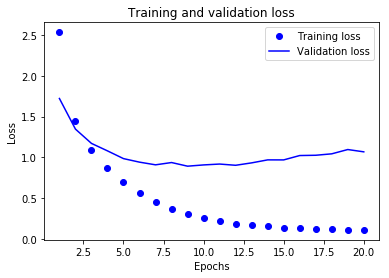

In [15]:
# 訓練データと検証データの損失値をプロット
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

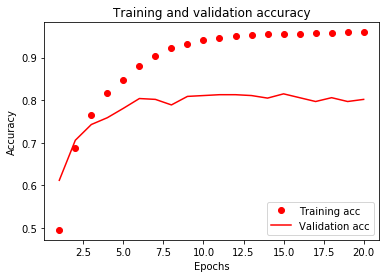

In [17]:
# 訓練データと検証データの正解率をプロット
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

　上図を見ると、8エポックの後、ネットワークは過学習に陥っている。

In [18]:
# 8エポックで訓練
model.fit(partial_x_train, partial_y_train, epochs=8, batch_size=512, validation_data=(x_val, y_val))
# 最終結果を表示
print(model.evaluate(x_test, y_test))

Train on 7982 samples, validate on 1000 samples
Epoch 1/8
7982/7982 [==============================] - 1s 72us/step - loss: 0.1055 - acc: 0.9575 - val_loss: 1.1033 - val_acc: 0.7990
Epoch 2/8
7982/7982 [==============================] - 1s 66us/step - loss: 0.1019 - acc: 0.9579 - val_loss: 1.1133 - val_acc: 0.8020
Epoch 3/8
7982/7982 [==============================] - 1s 65us/step - loss: 0.1028 - acc: 0.9592 - val_loss: 1.0965 - val_acc: 0.7960
Epoch 4/8
7982/7982 [==============================] - 1s 66us/step - loss: 0.1030 - acc: 0.9575 - val_loss: 1.1221 - val_acc: 0.7970
Epoch 5/8
7982/7982 [==============================] - 1s 65us/step - loss: 0.0970 - acc: 0.9590 - val_loss: 1.1496 - val_acc: 0.8020
Epoch 6/8
7982/7982 [==============================] - 1s 66us/step - loss: 0.0988 - acc: 0.9565 - val_loss: 1.2267 - val_acc: 0.7870
Epoch 7/8
7982/7982 [==============================] - 1s 66us/step - loss: 0.0960 - acc: 0.9575 - val_loss: 1.1766 - val_acc: 0.7990
Epoch 8/8
2246

　今回の学習の結果、76％の精度を達成できた。

In [20]:
# 訓練済みモデルで予測値を生成
pred = model.predict(x_test)

In [21]:
# 予測値は、46次元ベクトルであり、このベクトルの係数を合計すると1となる
print(pred[0].shape, np.sum(pred[0]))

(46,) 1.0000001


In [22]:
# 46次元ベクトルの中で最も大きな係数（＝最も高い確率）のインデックスが予測されたクラスとなる
np.argmax(pred[0])

3

In [30]:
y_pred = np.argmax(pred, axis=1) # 列方向に最大値を算出し、予測ラベルを1行に並べる
print(y_pred, test_labels)

[ 3 10  1 ...  3  3  1] [ 3 10  1 ...  3  3 24]


In [34]:
# 正解率
# 単純に正解と同一の予測値の数をカウントするだけ
# model.evaluate(x_test, y_test) と同じくらいの正解率になるはず
print('正解率：', len(y_pred[y_pred == test_labels]) / len(y_pred) * 100, '%')

正解率： 76.49154051647373 %


## ニューラルネットワークの検証

　今回、中間層の隠れユニット数を64にしたが、これは最終的な出力が46次元であるため、隠れユニット数が46より小さい中間層は避けるべきだからである。
例えば、4ユニットなど、46よりずっと少ない隠れユニット数の中間層を使用した場合、情報のボトルネックが発生し得る。これを以下のサンプルコードで検証する。

In [36]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.fit(partial_x_train, partial_y_train, epochs=8, batch_size=512, validation_data=(x_val, y_val))
print(model.evaluate(x_test, y_test))

Train on 7982 samples, validate on 1000 samples
Epoch 1/8
7982/7982 [==============================] - 1s 103us/step - loss: 3.5769 - acc: 0.2087 - val_loss: 3.3598 - val_acc: 0.3870
Epoch 2/8
7982/7982 [==============================] - 1s 68us/step - loss: 3.1407 - acc: 0.4449 - val_loss: 3.0620 - val_acc: 0.4580
Epoch 3/8
7982/7982 [==============================] - 1s 68us/step - loss: 2.8429 - acc: 0.3681 - val_loss: 2.8636 - val_acc: 0.3270
Epoch 4/8
7982/7982 [==============================] - 1s 67us/step - loss: 2.6283 - acc: 0.3355 - val_loss: 2.7267 - val_acc: 0.3310
Epoch 5/8
7982/7982 [==============================] - 1s 70us/step - loss: 2.4637 - acc: 0.3458 - val_loss: 2.6362 - val_acc: 0.3340
Epoch 6/8
7982/7982 [==============================] - 1s 69us/step - loss: 2.3190 - acc: 0.3646 - val_loss: 2.5125 - val_acc: 0.3540
Epoch 7/8
7982/7982 [==============================] - 1s 68us/step - loss: 2.1667 - acc: 0.3969 - val_loss: 2.3854 - val_acc: 0.3740
Epoch 8/8
224

 上のサンプルでも分かるように、情報のボトルネックが発生した（損失が起こった）場合、学習は上手くいかない。
このネットワークでは、46クラスの分離超平面を復元するための情報を4次元表現空間に詰め込もうとしているために損失が起こっている。

　次に、以下のような実習を行い、ネットワークの性能を検証する。

- 隠れユニットを32ユニットに減らす
- 隠れユニットを128ユニットに増やす
- 隠れ層を1つに減らす
- 隠れ層を3つに増やす

In [37]:
# 隠れユニットを32ユニットに減らす
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.fit(partial_x_train, partial_y_train, epochs=8, batch_size=512, validation_data=(x_val, y_val))
print(model.evaluate(x_test, y_test)) # -> 正解率76％

Train on 7982 samples, validate on 1000 samples
Epoch 1/8
7982/7982 [==============================] - 1s 102us/step - loss: 3.1362 - acc: 0.3879 - val_loss: 2.4698 - val_acc: 0.5690
Epoch 2/8
7982/7982 [==============================] - 1s 70us/step - loss: 2.0378 - acc: 0.6438 - val_loss: 1.7732 - val_acc: 0.6460
Epoch 3/8
7982/7982 [==============================] - 1s 69us/step - loss: 1.4868 - acc: 0.7041 - val_loss: 1.4398 - val_acc: 0.6990
Epoch 4/8
7982/7982 [==============================] - 1s 70us/step - loss: 1.1893 - acc: 0.7483 - val_loss: 1.2736 - val_acc: 0.7210
Epoch 5/8
7982/7982 [==============================] - 1s 68us/step - loss: 0.9984 - acc: 0.7886 - val_loss: 1.1678 - val_acc: 0.7560
Epoch 6/8
7982/7982 [==============================] - 1s 68us/step - loss: 0.8561 - acc: 0.8180 - val_loss: 1.0824 - val_acc: 0.7750
Epoch 7/8
7982/7982 [==============================] - 1s 69us/step - loss: 0.7377 - acc: 0.8420 - val_loss: 1.0306 - val_acc: 0.7890
Epoch 8/8
224

In [38]:
# 隠れユニットを128ユニットに増やす
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.fit(partial_x_train, partial_y_train, epochs=8, batch_size=512, validation_data=(x_val, y_val))
print(model.evaluate(x_test, y_test)) # -> 正解率77％

Train on 7982 samples, validate on 1000 samples
Epoch 1/8
7982/7982 [==============================] - 1s 101us/step - loss: 2.1960 - acc: 0.5574 - val_loss: 1.3849 - val_acc: 0.6800
Epoch 2/8
7982/7982 [==============================] - 1s 71us/step - loss: 1.1257 - acc: 0.7532 - val_loss: 1.1107 - val_acc: 0.7450
Epoch 3/8
7982/7982 [==============================] - 1s 70us/step - loss: 0.7833 - acc: 0.8311 - val_loss: 0.9682 - val_acc: 0.7860
Epoch 4/8
7982/7982 [==============================] - 1s 70us/step - loss: 0.5759 - acc: 0.8810 - val_loss: 0.9411 - val_acc: 0.8140
Epoch 5/8
7982/7982 [==============================] - 1s 71us/step - loss: 0.4113 - acc: 0.9133 - val_loss: 0.8923 - val_acc: 0.8120
Epoch 6/8
7982/7982 [==============================] - 1s 70us/step - loss: 0.3231 - acc: 0.9305 - val_loss: 0.8599 - val_acc: 0.8150
Epoch 7/8
7982/7982 [==============================] - 1s 71us/step - loss: 0.2474 - acc: 0.9440 - val_loss: 0.9353 - val_acc: 0.8110
Epoch 8/8
224

In [39]:
# 隠れ層を1つに減らす
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.fit(partial_x_train, partial_y_train, epochs=8, batch_size=512, validation_data=(x_val, y_val))
print(model.evaluate(x_test, y_test)) # -> 正解率79％

Train on 7982 samples, validate on 1000 samples
Epoch 1/8
7982/7982 [==============================] - 1s 94us/step - loss: 2.4586 - acc: 0.5540 - val_loss: 1.7369 - val_acc: 0.6550
Epoch 2/8
7982/7982 [==============================] - 1s 68us/step - loss: 1.4085 - acc: 0.7300 - val_loss: 1.3097 - val_acc: 0.7290
Epoch 3/8
7982/7982 [==============================] - 1s 68us/step - loss: 1.0383 - acc: 0.7937 - val_loss: 1.1117 - val_acc: 0.7710
Epoch 4/8
7982/7982 [==============================] - 1s 70us/step - loss: 0.8193 - acc: 0.8340 - val_loss: 1.0077 - val_acc: 0.7880
Epoch 5/8
7982/7982 [==============================] - 1s 71us/step - loss: 0.6617 - acc: 0.8668 - val_loss: 0.9340 - val_acc: 0.8060
Epoch 6/8
7982/7982 [==============================] - 1s 68us/step - loss: 0.5405 - acc: 0.8909 - val_loss: 0.8877 - val_acc: 0.8140
Epoch 7/8
7982/7982 [==============================] - 1s 70us/step - loss: 0.4473 - acc: 0.9103 - val_loss: 0.8495 - val_acc: 0.8220
Epoch 8/8
2246

In [40]:
# 隠れ層を3つに増やす
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.fit(partial_x_train, partial_y_train, epochs=8, batch_size=512, validation_data=(x_val, y_val))
print(model.evaluate(x_test, y_test)) # -> 正解率78％

Train on 7982 samples, validate on 1000 samples
Epoch 1/8
7982/7982 [==============================] - 1s 101us/step - loss: 2.6778 - acc: 0.4491 - val_loss: 1.7213 - val_acc: 0.6360
Epoch 2/8
7982/7982 [==============================] - 1s 70us/step - loss: 1.4380 - acc: 0.6987 - val_loss: 1.3393 - val_acc: 0.7040
Epoch 3/8
7982/7982 [==============================] - 1s 69us/step - loss: 1.0765 - acc: 0.7687 - val_loss: 1.1914 - val_acc: 0.7370
Epoch 4/8
7982/7982 [==============================] - 1s 69us/step - loss: 0.8343 - acc: 0.8161 - val_loss: 1.0787 - val_acc: 0.7620
Epoch 5/8
7982/7982 [==============================] - 1s 70us/step - loss: 0.6721 - acc: 0.8540 - val_loss: 0.9987 - val_acc: 0.7940
Epoch 6/8
7982/7982 [==============================] - 1s 70us/step - loss: 0.5338 - acc: 0.8830 - val_loss: 0.9786 - val_acc: 0.7890
Epoch 7/8
7982/7982 [==============================] - 1s 69us/step - loss: 0.4154 - acc: 0.9132 - val_loss: 1.0010 - val_acc: 0.7920
Epoch 8/8
224